In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# scanpy is used for single cell analysis

In [2]:
# Modify this as needed! I upload the zip file first then upzip it on sockeye. 
#adata = sc.read_h5ad("/arc/project/st-jimsun-1/axu03/vcc_data/adata_Training.h5ad")
adata = sc.read_h5ad("/scratch/st-evanesce-1/vivian/vcc_data/adata_Training.h5ad")

In [11]:
# check training data 
print(adata)
print(adata.shape)  # (n_cells, n_genes)
print(adata.obs.head())
print(adata.var.head())

AnnData object with n_obs × n_vars = 221273 × 18080
    obs: 'target_gene', 'guide_id', 'batch'
    var: 'gene_id'
(221273, 18080)
                                   target_gene                   guide_id  \
AAACAAGCAACCTTGTACTTTAGG-Flex_1_01       CHMP3  CHMP3_P1P2_A|CHMP3_P1P2_B   
AAACAAGCATTGCCGCACTTTAGG-Flex_1_01        AKT2    AKT2_P1P2_A|AKT2_P1P2_B   
AAACCAATCAATGTTCACTTTAGG-Flex_1_01       SHPRH  SHPRH_P1P2_A|SHPRH_P1P2_B   
AAACCAATCCCTCGCTACTTTAGG-Flex_1_01      TMSB4X    TMSB4X_P1_A|TMSB4X_P1_B   
AAACCAATCTAAATCCACTTTAGG-Flex_1_01       KLF10      KLF10_P2_A|KLF10_P2_B   

                                        batch  
AAACAAGCAACCTTGTACTTTAGG-Flex_1_01  Flex_1_01  
AAACAAGCATTGCCGCACTTTAGG-Flex_1_01  Flex_1_01  
AAACCAATCAATGTTCACTTTAGG-Flex_1_01  Flex_1_01  
AAACCAATCCCTCGCTACTTTAGG-Flex_1_01  Flex_1_01  
AAACCAATCTAAATCCACTTTAGG-Flex_1_01  Flex_1_01  
                 gene_id
SAMD11   ENSG00000187634
NOC2L    ENSG00000188976
KLHL17   ENSG00000187961
PLEKHN1  ENSG00000

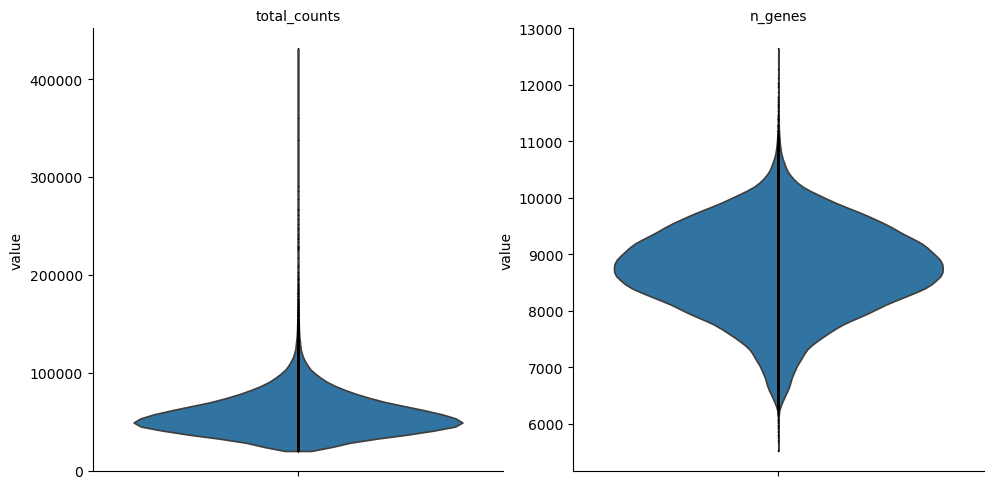

In [6]:
if hasattr(adata.X, "toarray"):  # sparse matrix
    adata.obs['total_counts'] = np.array(adata.X.sum(axis=1)).flatten()
else:
    adata.obs['total_counts'] = adata.X.sum(axis=1)
# Number of nonzero genes per guide
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1 if hasattr(adata.X, "A1") else (adata.X > 0).sum(axis=1)
# Make a violin plot: number of total gene counts per cell + number of non-zero count genes per cell
sc.pl.violin(adata, ['total_counts', 'n_genes'], jitter=0, multi_panel=True, save='violin.png')

ACTB      93888584.0
CD24      54895904.0
POU5F1    38948344.0
EEF2      33064416.0
HSPA8     31512622.0
TMSB4X    29862872.0
OAZ1      29423284.0
ACTG1     29189972.0
TUBB2B    26842304.0
LDHB      25063512.0
dtype: float32


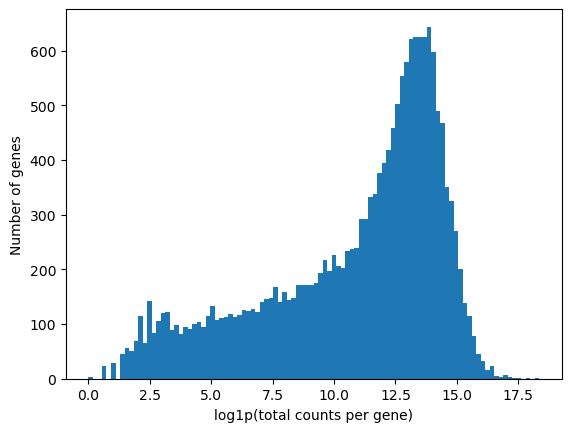

In [7]:
gene_counts = np.array(adata.X.sum(axis=0)).flatten() if hasattr(adata.X, "toarray") else adata.X.sum(axis=0).A1
gene_counts_series = pd.Series(gene_counts, index=adata.var_names)

# CHeck top expressed genes
print(gene_counts_series.sort_values(ascending=False).head(10))
# Plot histogram of log transformed total counts per gene to check gene distribution
plt.hist(np.log1p(gene_counts_series), bins=100)
plt.xlabel('log1p(total counts per gene)')
plt.ylabel('Number of genes')
plt.show()

/home/axu03/.conda/envs/vcc_py3.10/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:385: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


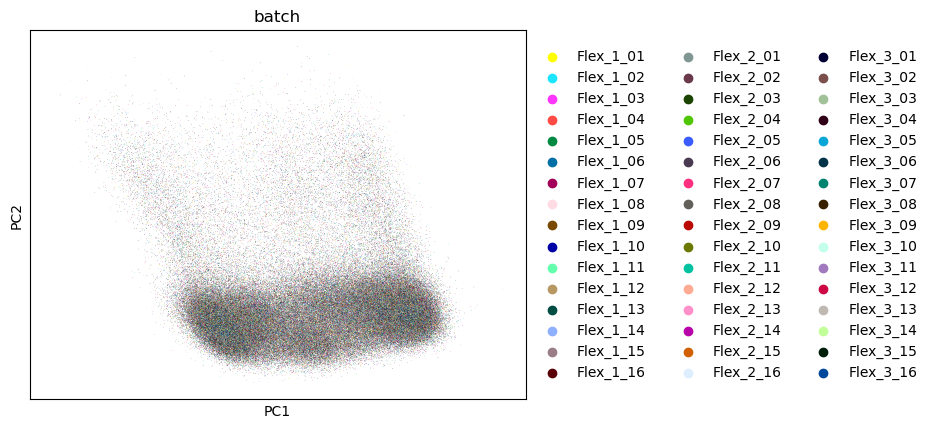

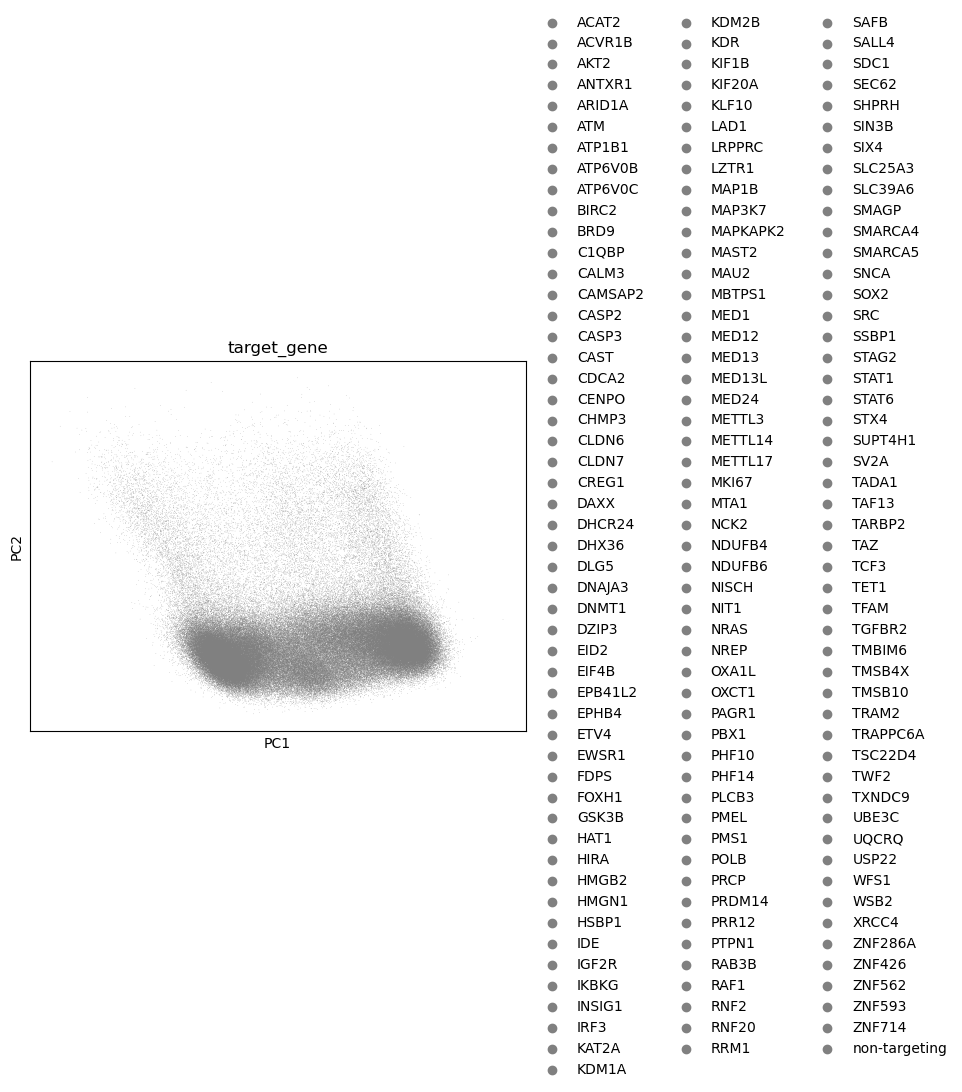

In [8]:
sc.pp.normalize_total(adata, target_sum=1e4)  # CPM-like normalization
sc.pp.log1p(adata)

# Make categorical
adata.obs['batch'] = adata.obs['batch'].astype('category')
adata.obs['target_gene'] = adata.obs['target_gene'].astype('category')

sc.settings.figdir = './figures'
os.makedirs(sc.settings.figdir, exist_ok=True)

# Angela: I'm not too sure how to color the PCA/UMAP since there are 200 different interferences. 
# I'm still thinking about how to explore and potentially remove batch effects. 

# PCA plot of top 2000 most variable genes 
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat')
adata_pca = adata[:, adata.var['highly_variable']] if 'highly_variable' in adata.var else adata
sc.tl.pca(adata_pca, svd_solver='arpack')
sc.pl.pca(adata_pca, color='batch', save='_pca_batch.png')
# Save PCA plot colored by target_gene as a PNG
sc.pl.pca(adata_pca, color='target_gene', save='_pca_target.png')

/home/axu03/.conda/envs/vcc_py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


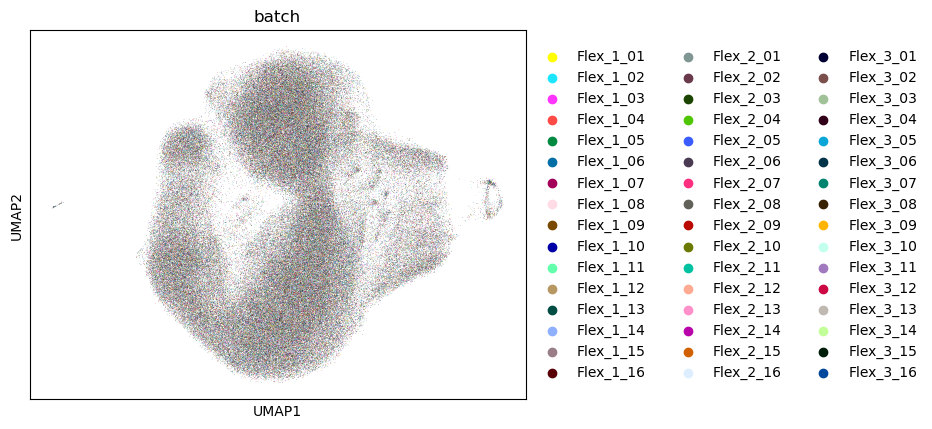

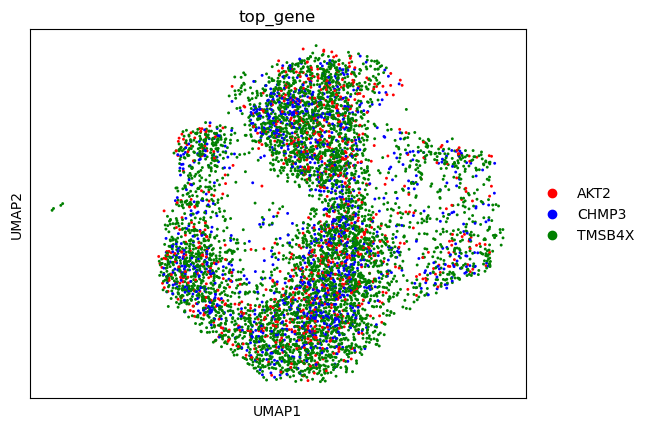

In [9]:
# Compute neighbors & UMAP
sc.pp.neighbors(adata_pca, n_neighbors=15, n_pcs=20)
sc.tl.umap(adata_pca)
# UMAP colored by batch
sc.pl.umap(
    adata_pca,
    color='batch',
    save='_umap_batch.png',
    show=True
)

# UMAP colored by a small subset of target genes, just to check if they separate (no they don't!)
top_genes = ['CHMP3', 'AKT2', 'TMSB4X']
adata_subset = adata_pca[adata_pca.obs['target_gene'].isin(top_genes)].copy()
adata_subset.obs['top_gene'] = adata_subset.obs['target_gene']
adata_subset.obs['top_gene'] = adata_subset.obs['top_gene'].astype('category')
sc.pl.umap(
    adata_subset,
    color='top_gene',        # use the new column
    palette=['red','blue','green'],  # optional: assign colors manually
    save='_umap_topgenes.png',
    show=True
)

In [3]:
import cell_eval
# cell_eval is the CLI tool used for evaluation and submisson, see: https://pypi.org/project/cell-eval/
# I pip installed it in my conda env
from cell_eval import MetricsEvaluator
from cell_eval.data import build_random_anndata, downsample_cells
from cell_eval import score_agg_metrics

### Baseline Model

In [ ]:
# Need to include negative control genes in the prediction, which will be used by cell-eval
# I just copied the ones from the training data and took 1000 randomly. Total num cells should be < 100,000 
output_h5ad = "/home/axu03/vcc scripts/adata_pred.h5ad"
validation_csv = "/arc/project/st-jimsun-1/axu03/vcc_data/pert_counts_Validation.csv"
test_csv = "/arc/project/st-jimsun-1/axu03/vcc_data/pert_counts_Test.csv"

test_set = pd.read_csv(test_csv)
expected_perturbations = test_set["target_gene"].tolist()

expected_genes_file = "/home/axu03/vcc scripts/expected_genes.txt"
np.savetxt(expected_genes_file, adata.var_names, fmt="%s")
genes = adata.var_names

# Baseline prediction model:
mean_expression = np.asarray(adata.X.mean(axis=0)).ravel()
preds_list = []
for tg in expected_perturbations:
    preds_list.append(mean_expression)
pred_df = pd.DataFrame(preds_list, columns=genes)
pred_df.insert(0, "target_gene", expected_perturbations)

In [9]:
# add negative control cells
ntc_cells = adata[adata.obs["target_gene"] == "non-targeting"]
n_ntc = min(1000, ntc_cells.n_obs)
sample_indices = np.random.choice(ntc_cells.n_obs, n_ntc, replace=False)
ntc_sample = ntc_cells[sample_indices]
ntc_df = pd.DataFrame(
    ntc_sample.X.toarray() if hasattr(ntc_sample.X, "toarray") else ntc_sample.X,
    columns=ntc_sample.var_names
)
ntc_df.insert(0, "target_gene", ["non-targeting"] * n_ntc)

# Merge predicted cells and control cells
pred_df_full = pd.concat([pred_df, ntc_df], ignore_index=True)


adata_pred = sc.AnnData(X=pred_df_full[genes].values.astype(np.float32))
adata_pred.var_names = genes
adata_pred.obs["target_gene"] = pred_df_full["target_gene"].values.astype(str)

# log1p transforms the data as expected by cell-eval
adata_pred.X = np.log1p(adata_pred.X)
adata_pred.write(output_h5ad)
print(f"Saved prediction AnnData to {output_h5ad}")

# ----- Run this in terminal to generate the .vcc file for submission --------------------------------------------------------------------------------
# cell-eval prep \
#   -i adata_pred.h5ad \
#   -g expected_genes.txt \
#   -o submission.vcc

Saved prediction AnnData to /home/axu03/vcc scripts/adata_pred.h5ad


In [12]:
print(pred_df_full.shape)

(1100, 18081)


### Ridge Regression Model

In [19]:
output_h5ad = "/scratch/st-evanesce-1/vivian/adata_ridge_pred.h5ad"
validation_csv = "/scratch/st-evanesce-1/vivian/vcc_data/pert_counts_Validation.csv"
test_csv = "/scratch/st-evanesce-1/vivian/vcc_data/pert_counts_Test.csv"

val_set = pd.read_csv(validation_csv)
expected_perturbations_val = val_set["target_gene"].tolist()

test_set = pd.read_csv(test_csv)
expected_perturbations_test = test_set["target_gene"].tolist()

expected_genes_file = "/scratch/st-evanesce-1/vivian/expected_genes.txt"
np.savetxt(expected_genes_file, adata.var_names, fmt="%s")
genes = adata.var_names

In [20]:
# Training model
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.multioutput import MultiOutputRegressor
import time

start = time.time()

train_target_genes = adata.obs["target_gene"].values
unique_genes = sorted(set(train_target_genes))
gene_to_idx = {g: i for i, g in enumerate(unique_genes)}

# one-hot encode the 18,080 columns: 1 if target, else 0
X_train = np.zeros((len(train_target_genes), len(unique_genes)))
for i, gene in enumerate(train_target_genes):
    X_train[i, gene_to_idx[gene]] = 1

# prepare y_train 
y_train = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X

model = MultiOutputRegressor(
    Ridge(alpha=1.0),
    n_jobs=-1
)
model.fit(X_train, y_train)

# encode test data
X_test = np.zeros((len(expected_perturbations_test), len(unique_genes)))
for i, target_gene in enumerate(expected_perturbations_test):
    if target_gene in gene_to_idx:
        X_test[i, gene_to_idx[target_gene]] = 1


predictions = model.predict(X_test)
pred_df = pd.DataFrame(predictions, columns=genes)
pred_df.insert(0, "target_gene", expected_perturbations_test)

end = time.time()
duration = end - start
print(f"Time elapsed: {duration/60} minutes")

Time elapsed: 9.548290109634399 minutes


In [21]:
# add negative control cells
ntc_cells = adata[adata.obs["target_gene"] == "non-targeting"]
n_ntc = min(1000, ntc_cells.n_obs)
sample_indices = np.random.choice(ntc_cells.n_obs, n_ntc, replace=False)
ntc_sample = ntc_cells[sample_indices]
ntc_df = pd.DataFrame(
    ntc_sample.X.toarray() if hasattr(ntc_sample.X, "toarray") else ntc_sample.X,
    columns=ntc_sample.var_names
)
ntc_df.insert(0, "target_gene", ["non-targeting"] * n_ntc)

# Merge predicted cells and control cells
pred_df_full = pd.concat([pred_df, ntc_df], ignore_index=True)

# Clip negative values to 0 in case ridge results in any
pred_df_full_values = pred_df_full[genes].values.astype(np.float32)
pred_df_full_values = np.maximum(pred_df_full_values, 0)


adata_pred = sc.AnnData(X=pred_df_full_values)
adata_pred.var_names = genes
adata_pred.obs["target_gene"] = pred_df_full["target_gene"].values.astype(str)

# log1p transforms the data as expected by cell-eval
adata_pred.X = np.log1p(adata_pred.X)
output_h5ad = "/scratch/st-evanesce-1/vivian/adata_ridge_pred.h5ad"
adata_pred.write(output_h5ad)
print(f"Saved prediction AnnData to {output_h5ad}")

# ----- Run this in terminal to generate the .vcc file for submission --------------------------------------------------------------------------------
# cell-eval prep \
#   -i adata_pred.h5ad \
#   -g expected_genes.txt \
#   -o submission.vcc

... storing 'target_gene' as categorical


Saved prediction AnnData to /scratch/st-evanesce-1/vivian/adata_ridge_pred.h5ad


In [ ]:
# if the results from Ridge with alpha=1 are bad, run a GridSearchCV or manually test alphas=[0.01, 0.1, 1.0, 10.0, 100.0]